# ORDINA CASE: BIKE RENTAL ANALYSIS

### MILAN RIBEL - Application: Data Science Traineeship

In this notebook you can find my solutions to the bike rental analysis case. First, the necessary libraries and the data is imported. Then follows a exploratory data analysis to find useful insights in the data followed by some data preprocessing. After this, 3 models are discussed. The first model will be a random forests model. This a more general data science model which can also be used for time series analysis. Next, a linear regression will be performed and lastly, an XGBoost regression will be conducted. After the fitting of these models to the data, they are compared by using the RMSE, MAE and R-squared metrics. This will determine the best model and that model will be used to forecast the bike rentals for the next 3 days.

A quick overview:
1. [Loading necessary libraries and data](#1)
2. [Exploratory Data Analysis](#2)
3. [Data Preprocessing](#3)
4. [Random Forest Regression](#4)
5. [Linear Regression](#5)
6. [XGBoost Regression](#6)
7. [Forecasting the next 3 days](#7)
8. [Productionalizing final model](#8)

### 1. Loading necessary libraries and data <a class="anchor" id="1"></a>

In [1]:
# packages for data
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.signal import savgol_filter

# packages for visualization
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.io as pio
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# models
import pmdarima as pm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb

# tools for models
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# for bonus question
import pickle
from flask import Flask, render_template, request

In [2]:
# create requirements.txt
!pipreqsnb --force .

pipreqs  --force .
INFO: Successfully saved requirements file in ./requirements.txt


In [77]:
# read data
df = pd.read_csv('Data/bike.csv')

### 2. Exploratory Data Analysis <a class="anchor" id="2"></a>

The analysis starts with an exploratory data analysis. Let's begin by checking how the data set is constructed.

In [49]:
df.head()

dteday  season  yr  mnth  holiday  weekday  workingday  weathersit  \
0  2011-01-01       1   0     1        0        6           0           2   
1  2011-01-02       1   0     1        0        0           0           2   
2  2011-01-03       1   0     1        0        1           1           1   
3  2011-01-04       1   0     1        0        2           1           1   
4  2011-01-05       1   0     1        0        3           1           1   

       temp     atemp       hum  windspeed  casual  registered   cnt  
0  0.344167  0.363625  0.805833   0.160446     331         654   985  
1  0.363478  0.353739  0.696087   0.248539     131         670   801  
2  0.196364  0.189405  0.437273   0.248309     120        1229  1349  
3  0.200000  0.212122  0.590435   0.160296     108        1454  1562  
4  0.226957  0.229270  0.436957   0.186900      82        1518  1600

Now let's check what data type every column is in the dataset.

In [50]:
# check data types
df.dtypes

dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

First, the `dteday` column is converted to datetime type and the columns `season`, `mth`, `weekday` and `weathersit` are converted to categorical variables. The modelling will be done on the total number of bike rentals, so variables `casual` and `registered` can be dropped.

In [78]:
# change necessary datatypes and drop 'casual' and 'registered'
df['dteday']=pd.to_datetime(df['dteday'])
df['season'] = df['season'].astype('category')
df['mnth'] = df['mnth'].astype('category')
df['weekday'] = df['weekday'].astype('category')
df['weathersit'] = df['weathersit'].astype('category')
df = df.drop(['casual', 'registered'], axis =1)

# rename the categorical variables for visualization
df['season'] = df['season'].map({1:'winter',2:'spring',3:'summer',4:'fall'})
df['mnth'] = df['mnth'].map({1:'jan',2:'feb',3:'mar',4:'apr',5:'may',6:'jun',
                             7:'jul',8:'aug',9:'sep',10:'oct',11:'nov',12:'dec'})
df['weekday'] = df['weekday'].map({0:'mon',1:'tue',2:'wed',3:'thu',4:'fri',5:'sat',6:'sun'})
df['weathersit'] = df['weathersit'].map({1:'good',2:'medium',3:'bad'})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      728 non-null    datetime64[ns]
 1   season      728 non-null    category      
 2   yr          728 non-null    int64         
 3   mnth        728 non-null    category      
 4   holiday     728 non-null    int64         
 5   weekday     728 non-null    category      
 6   workingday  728 non-null    int64         
 7   weathersit  728 non-null    category      
 8   temp        728 non-null    float64       
 9   atemp       728 non-null    float64       
 10  hum         728 non-null    float64       
 11  windspeed   728 non-null    float64       
 12  cnt         728 non-null    int64         
dtypes: category(4), datetime64[ns](1), float64(4), int64(4)
memory usage: 55.2 KB


The dataset 'Bike' has 728 rows, one for each day from 2011-01-01 up to 2012-12-28. For each of these days there are 15 variables. The explanations of every variable is given in the Readme.txt file. There seem to be no missing values in the data set. The descriptive statistics of every numeric variable can now be checked.

In [79]:
# request the descriptive statistics
df.describe()

yr     holiday  workingday        temp       atemp         hum  \
count  728.000000  728.000000   728.00000  728.000000  728.000000  728.000000   
mean     0.498626    0.028846     0.68544    0.496430    0.475351    0.627990   
std      0.500342    0.167489     0.46466    0.182696    0.162553    0.142534   
min      0.000000    0.000000     0.00000    0.059130    0.079070    0.000000   
25%      0.000000    0.000000     0.00000    0.340000    0.338363    0.520000   
50%      0.000000    0.000000     1.00000    0.501250    0.488627    0.627083   
75%      1.000000    0.000000     1.00000    0.655833    0.609544    0.730104   
max      1.000000    1.000000     1.00000    0.861667    0.840896    0.972500   

        windspeed          cnt  
count  728.000000   728.000000  
mean     0.190406  4514.853022  
std      0.077380  1933.901301  
min      0.022392    22.000000  
25%      0.134950  3193.000000  
50%      0.180975  4551.000000  
75%      0.233211  5978.500000  
max      0.507463  8714.000000

Here the descriptive statistics such as the mean, median and standard deviation for the variables in the data set can be seen. On average, 4515 bikes are rented each day. <br>
Now analysis on the variables can be done. Let's start by plotting the total bike rentals as a time series.

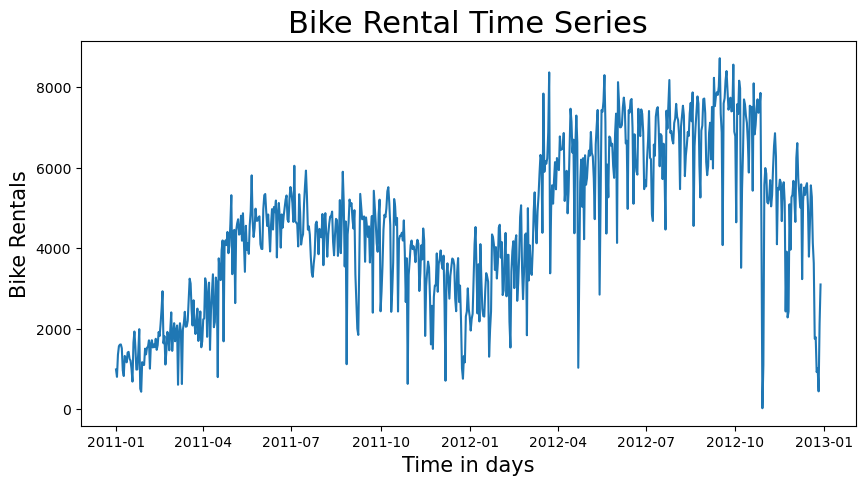

In [80]:
# plot the total bike rentals
plt.style.use('default')
plt.figure(figsize=(10,5))
plt.title("Bike Rental Time Series", fontsize = 22)
plt.ylabel("Bike Rentals", fontsize = 15)
plt.xlabel("Time in days", fontsize = 15)
plt.plot(df['dteday'], df['cnt'])
#plt.savefig('timeseries.png')

At first glance, the bike rental service seems to gain popularity through time. In the summer period, more bikes seem to be used than in the winter period. Let's plot the temperature and see if we find the same trend.

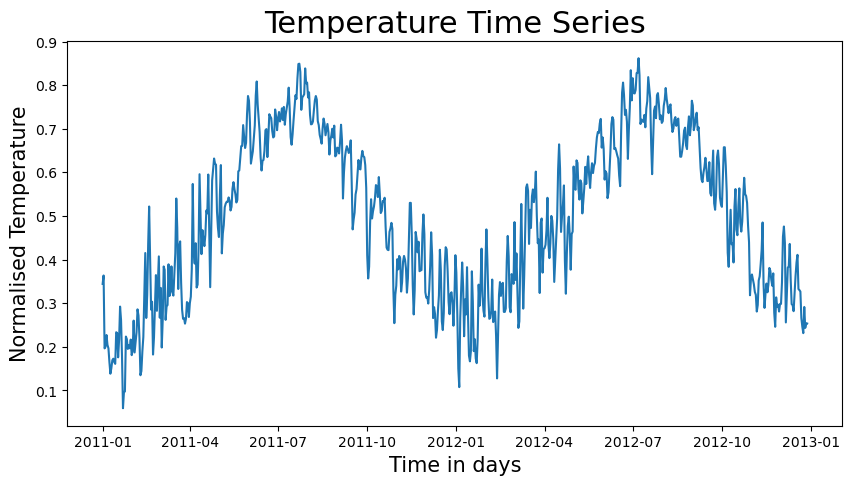

In [81]:
# plot the temperature
plt.figure(figsize=(10,5))
plt.title("Temperature Time Series", fontsize = 22)
plt.ylabel("Normalised Temperature", fontsize = 15)
plt.xlabel("Time in days", fontsize = 15)
plt.plot(df['dteday'], df['temp'])
#plt.savefig('temptimeseries.png')

The similarity is not hard to find. Also, it can be that people are more interested in bike rental services when it is warmer outside. This information can be useful when deciding what variables are used in the models. <br>
Next, some relations between different variables can be checked. First, the total bikes per season are checked.

In [82]:
# plot histogram
fig = px.histogram(df,x='season',y='cnt',template='presentation',color='season')
fig.update_layout(bargap=0.2,
                 title="Bike Rentals per season",
                 yaxis_title="Total bike rentals",
                 xaxis_title="Season")
#pio.write_image(fig, 'hist_season.png', format='png', width=800, height=400)
fig.show()

When looking at the histogram for the season variable, it can be seen that rental bikes seem more popular in the summer and in fall than in spring. The weather and time of year seem to be an important factor for people to use rental bikes. <br>
This can be looked into more specifically, let's look at the bike rentals per month.

In [83]:
# plot histogram
fig = px.histogram(df,x='mnth',y='cnt',template='presentation',color='mnth')
fig.update_layout(bargap=0.2,
                 title="Bike Rentals per month",
                 yaxis_title="Total bike rentals",
                 xaxis_title="Month")
#pio.write_image(fig, 'hist_month.png', format='png', width=800, height=400)
fig.show()

The rental bikes seem to be most popular during the months june, juli, august and september. <br>
How about the popularity on the days of the week?

In [84]:
# plot histogram
fig = px.histogram(df,x='weekday',y='cnt',template='presentation',color='weekday')
fig.update_layout(bargap=0.2,
                 title="Bike Rentals per day",
                 yaxis_title="Total bike rentals",
                 xaxis_title="Day")
#pio.write_image(fig, 'hist_day.png', format='png', width=800, height=400)
fig.show()

There seems to be no preference in weekday whenever people want to use rental bikes. <br>
Some people might be more interested in using rental bikes on workingdays, let's see if this is the case.

In [85]:
# plot histogram
mean_workingday = df.groupby('workingday')['cnt'].mean()
fig = px.histogram(mean_workingday,x=mean_workingday.index,y='cnt',template='presentation'
                   ,color=mean_workingday.index)
fig.update_layout(bargap=0.5,
                 title="Working day bike rentals",
                 yaxis_title="Average bike rentals",
                 xaxis_title="Working day",
                 xaxis_type='category')
#pio.write_image(fig, 'hist_workingday.png', format='png', width=800, height=400)
fig.show()

On working days, rental bikes seem more popular. But only by a small margin. The same plot can be made for holidays.

In [86]:
# plot histogram
mean_holiday = df.groupby('holiday')['cnt'].mean()
fig = px.histogram(mean_holiday,x=mean_holiday.index,y='cnt',template='presentation'
                   ,color=mean_holiday.index)
fig.update_layout(bargap=0.5,
                 title="Holiday bike rentals",
                 yaxis_title="Average bike rentals",
                 xaxis_title="Holiday",
                 xaxis_type='category')
#pio.write_image(fig, 'hist_holiday.png', format='png', width=800, height=400)
fig.show()

On holidays, rental bikes seem to be less popular. <br>
As seen before, the temperature seems be an important factor for the popularity of the rental bikes. There is also some info on the weather situation. There is good, medium and bad weather:
* good: Clear, Few clouds, Partly cloudy, Partly cloudy
* medium: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
* bad: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

In the Readme.txt file, there is a fourth category for stormlike weather but there is no entry in the data set with weather situation level 4. Let's see how the bike rentals are devided between these weather situation categories.

In [87]:
# plot histogram
mean_weather = df.groupby('weathersit')['cnt'].mean()
fig = px.histogram(mean_weather,x=mean_weather.index,y='cnt',template='presentation'
                   ,color=mean_weather.index)
fig.update_layout(bargap=0.5,
                 title="Bike rentals by weather situation",
                 yaxis_title="Average bike rentals",
                 xaxis_title="Weather situation")
#pio.write_image(fig, 'hist_weather.png', format='png', width=800, height=400)
fig.show()

As expected, rental bikes seem to be more popular when the weather is better.<br>
Now the relations between the variables can be checked. The correlation matrix shows the correlation coëfficiënts for all the variables.

In [88]:
# calculate correlations
df_for_corr = df.drop(['dteday','season','workingday','yr','mnth','holiday',
                      'weekday','weathersit'], axis=1)
corr_matrix = np.round(df_for_corr.corr(),2)

# make correlation plot
fig = px.imshow(corr_matrix,text_auto=True,template='presentation')
fig.update_layout(title="Correlation matrix")
#pio.write_image(fig, 'correlation_matrix.png', format='png')
fig.show()

The variables `temp` and `atemp` have a high positive correlation with the `cnt` variable. `hum` and `windspeed` have a rather low negative correlation with the `cnt` variable, but can still be used for modelling the bike rentals. Also, the variables `temp` and `atemp` have a high correlation between themselves. The pairplot is used to see what relationship these variables have.

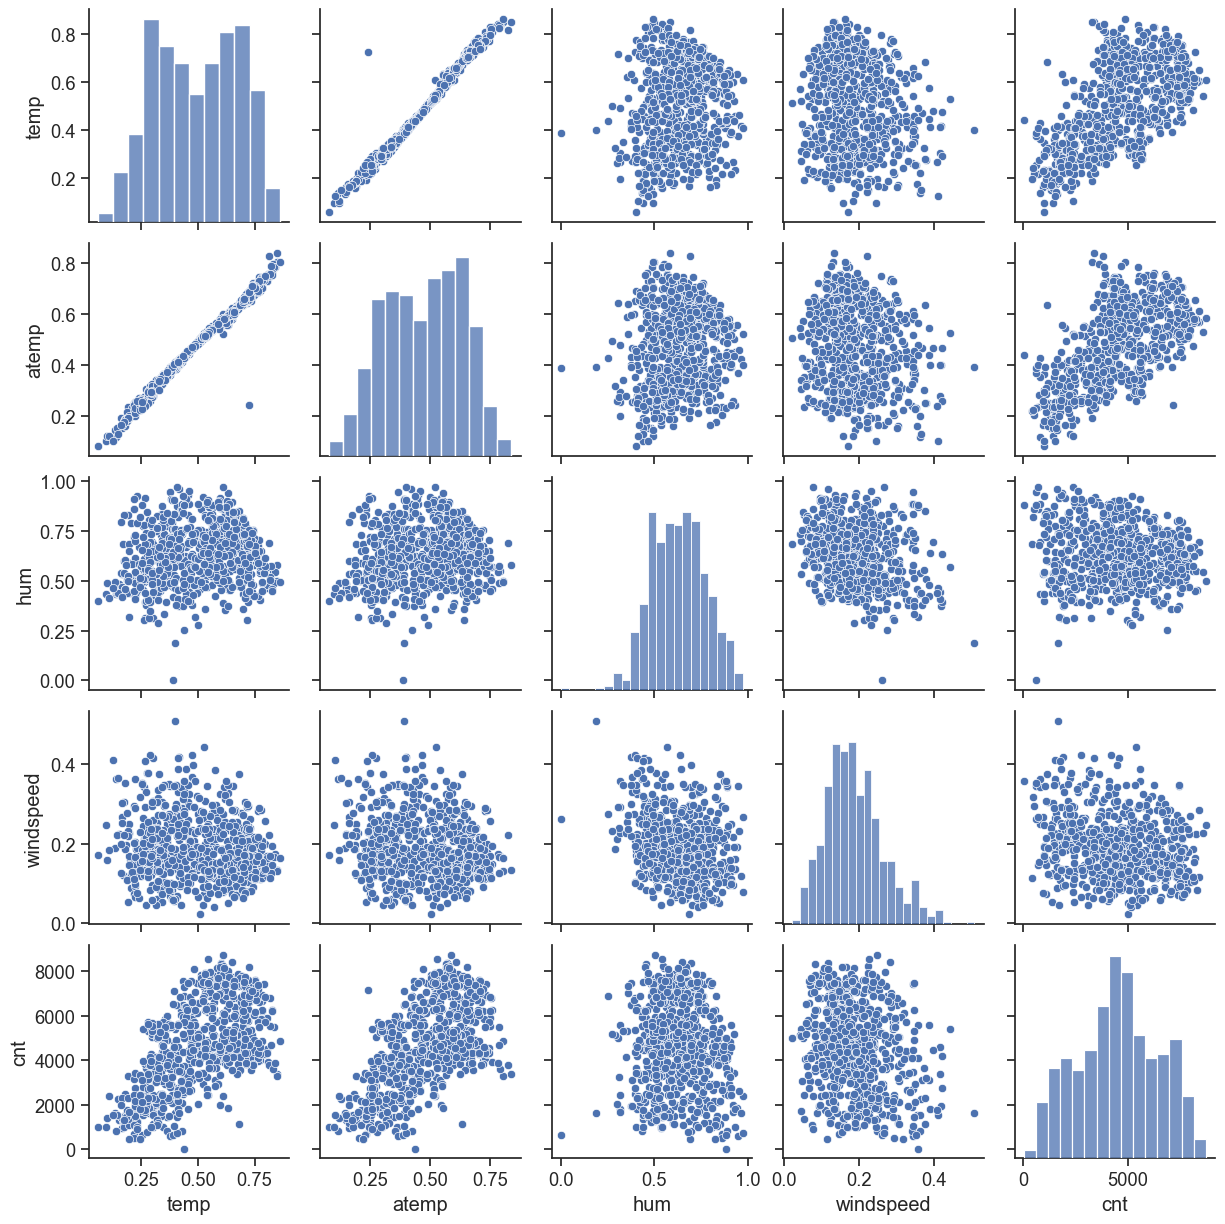

In [89]:
# create pairplot of numerical variables
sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.pairplot(df.drop(['dteday','season','workingday','yr','mnth','holiday',
                      'weekday','weathersit'], axis=1))
#plt.savefig('pairplot.png')

The pairplot shows a very linear relationship between the variables `temp` and `atemp`. This can be a form of multicollinearity. The VIF's will be checked to see what variables introduce multicollinearity in the data set.

### 3. Data Preprocessing <a class="anchor" id="3"></a>

Before the models can be build, some data preprocessing is needed. The variables `season`, `mnth`, `weekday` and `weathersit` are categorical variables so they need to be dummy coded. `yr`, `holiday` and `workingday` are already dummy coded. Also, the variable `dteday` will serve as index, therefore is must be set as index.

In [90]:
# set time index and dummy code categorical variables
df.set_index('dteday', inplace=True)
df = pd.get_dummies(df, columns = ['season','weathersit','mnth','weekday'],drop_first=True)
df.head(5)

yr  holiday  workingday      temp     atemp       hum  windspeed  \
dteday                                                                         
2011-01-01   0        0           0  0.344167  0.363625  0.805833   0.160446   
2011-01-02   0        0           0  0.363478  0.353739  0.696087   0.248539   
2011-01-03   0        0           1  0.196364  0.189405  0.437273   0.248309   
2011-01-04   0        0           1  0.200000  0.212122  0.590435   0.160296   
2011-01-05   0        0           1  0.226957  0.229270  0.436957   0.186900   

             cnt  season_spring  season_summer  ...  mnth_sep  mnth_oct  \
dteday                                          ...                       
2011-01-01   985              0              0  ...         0         0   
2011-01-02   801              0              0  ...         0         0   
2011-01-03  1349              0              0  ...         0         0   
2011-01-04  1562              0              0  ...         0         0   
2011-01-05  1600              0              0  ...         0         0   

            mnth_nov  mnth_dec  weekday_tue  weekday_wed  weekday_thu  \
dteday                                                                  
2011-01-01         0         0            0            0            0   
2011-01-02         0         0            0            0            0   
2011-01-03         0         0            1            0            0   
2011-01-04         0         0            0            1            0   
2011-01-05         0         0            0            0            1   

            weekday_fri  weekday_sat  weekday_sun  
dteday                                             
2011-01-01            0            0            1  
2011-01-02            0            0            0  
2011-01-03            0            0            0  
2011-01-04            0            0            0  
2011-01-05            0            0            0  

[5 rows x 30 columns]

Now that the categorical variables and the time index are set, let's check how noisy the numerical variables are.

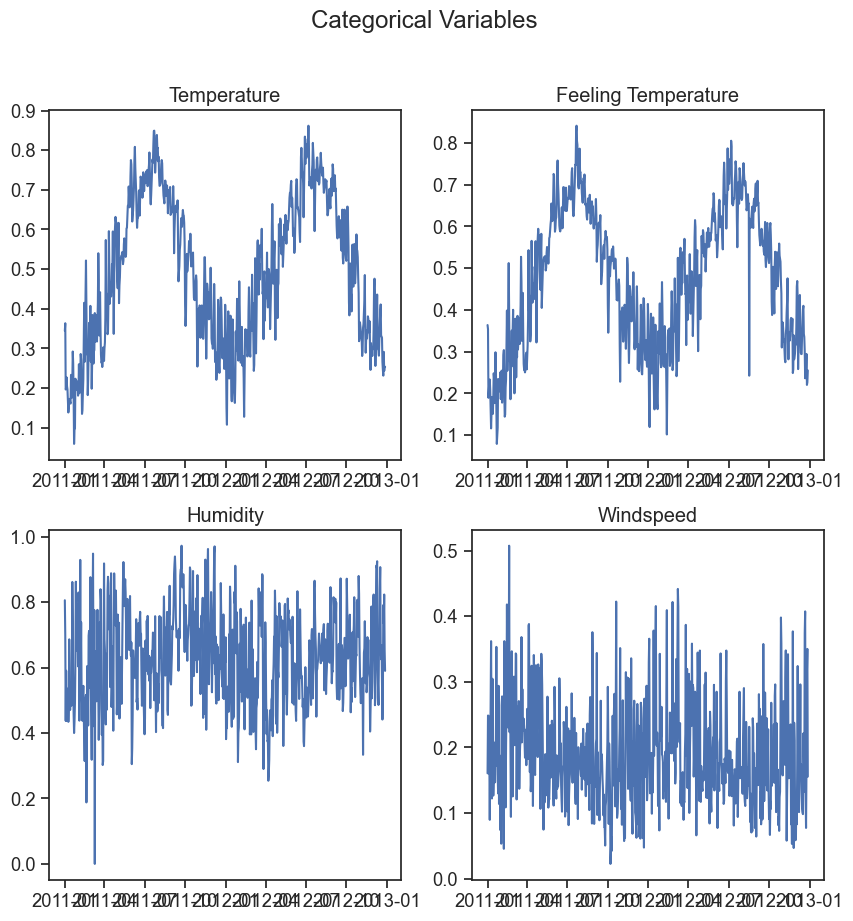

In [91]:
# plot the 4 categorical variables
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axs[0, 0].plot(df['temp'])
axs[0, 0].set_title('Temperature')
axs[0, 1].plot(df['atemp'])
axs[0, 1].set_title('Feeling Temperature')
axs[1, 0].plot(df['hum'])
axs[1, 0].set_title('Humidity')
axs[1, 1].plot(df['windspeed'])
axs[1, 1].set_title('Windspeed')
fig.suptitle('Categorical Variables')
plt.show()

As was seen at the beginning of the notebook, there is a lot of noise on the target variable `cnt` which makes it hard to predict. Also, a lot of noise is present in the variables `atemp`, `temp`, `hum` and `windspeed`. This is noise that can confuse the models. Therefore, smoothing will be done using the Savitzky-Golay filter. This method uses a window around a data point. Next, a polynomial is fitted through the data points in that window to estimate the center of the window. This method preserves peaks in the time series.

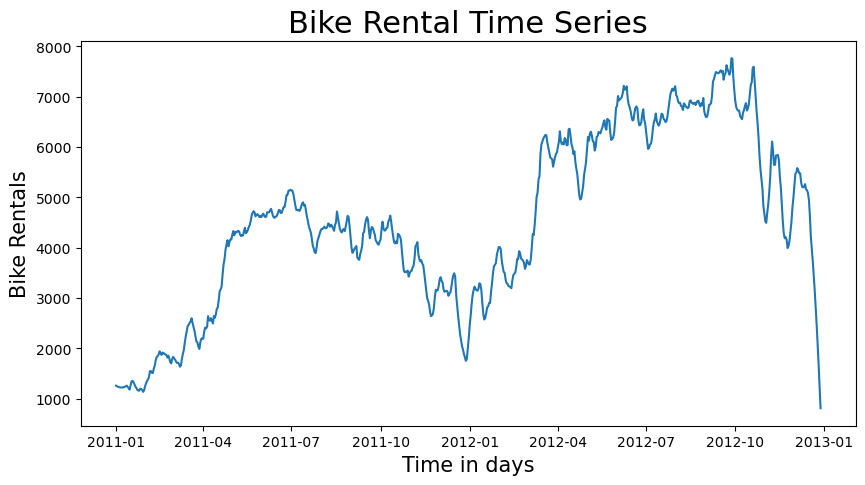

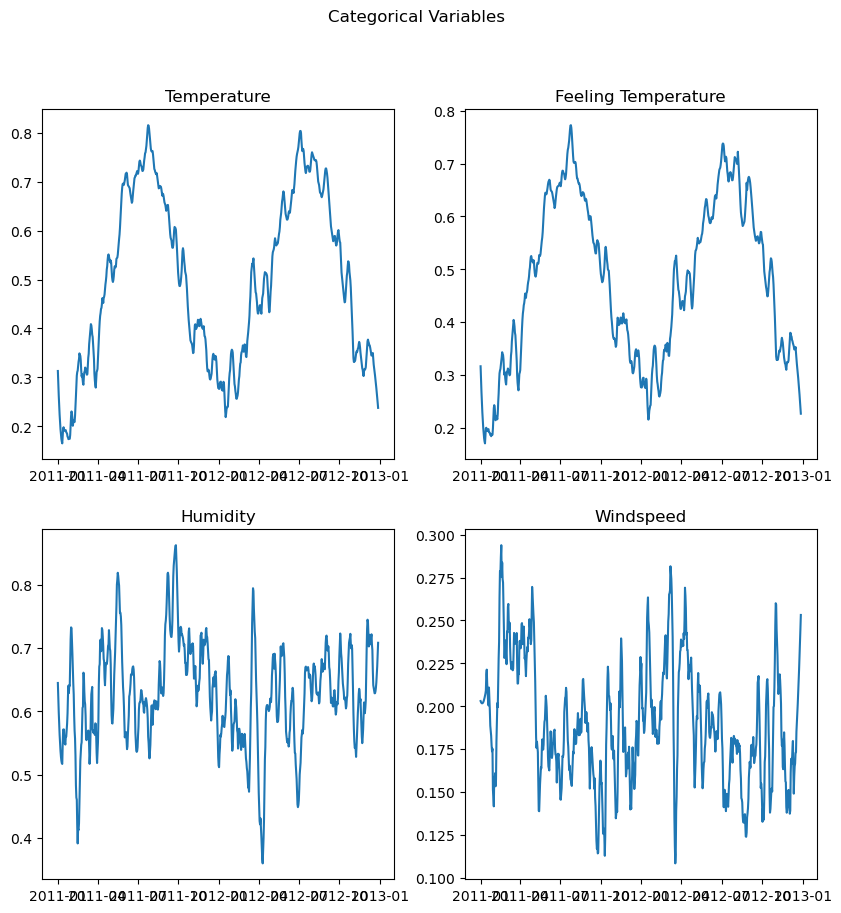

In [92]:
# apply Savitzky-Golay filter to variables
df['cnt'] = savgol_filter(df['cnt'], window_length=21, polyorder=2)
df['atemp'] = savgol_filter(df['atemp'], window_length=21, polyorder=2)
df['temp'] = savgol_filter(df['temp'], window_length=21, polyorder=2)
df['hum'] = savgol_filter(df['hum'], window_length=21, polyorder=2)
df['windspeed'] = savgol_filter(df['windspeed'], window_length=21, polyorder=2)

# plot smoothed time series
plt.style.use('default')
plt.figure(figsize=(10,5))
plt.title("Bike Rental Time Series", fontsize = 22)
plt.ylabel("Bike Rentals", fontsize = 15)
plt.xlabel("Time in days", fontsize = 15)
plt.plot(df['cnt'])
#plt.savefig('temptimeseries_smooth.png')

# plot the 4 categorical variables
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axs[0, 0].plot(df['temp'])
axs[0, 0].set_title('Temperature')
axs[0, 1].plot(df['atemp'])
axs[0, 1].set_title('Feeling Temperature')
axs[1, 0].plot(df['hum'])
axs[1, 0].set_title('Humidity')
axs[1, 1].plot(df['windspeed'])
axs[1, 1].set_title('Windspeed')
fig.suptitle('Categorical Variables')
plt.show()

Next, we need to check and choose what variables we will be retaining in the data set. For now, the data set has quite some variables and this might be too complex for the models. Therefore, the VIF's will be checked for all variables.

In [93]:
# split target from other features
x = df.drop('cnt', axis=1)
y = df['cnt']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()

# Compute VIF's'
vif = pd.DataFrame()
vif["Variable"] = x.columns
vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
print(vif)

             Variable         VIF
0               const  346.494202
1                  yr    1.173999
2             holiday         inf
3          workingday         inf
4                temp  441.516666
5               atemp  392.256849
6                 hum    2.336911
7           windspeed    2.272082
8       season_spring    7.619618
9       season_summer   11.355092
10        season_fall    8.403632
11  weathersit_medium    1.123619
12     weathersit_bad    1.086011
13           mnth_feb    1.948855
14           mnth_mar    3.247878
15           mnth_apr    7.011646
16           mnth_may    9.479889
17           mnth_jun   11.831547
18           mnth_jul   14.227491
19           mnth_aug   13.062343
20           mnth_sep    8.961254
21           mnth_oct    7.023631
22           mnth_nov    5.459317
23           mnth_dec    3.469443
24        weekday_tue         inf
25        weekday_wed         inf
26        weekday_thu         inf
27        weekday_fri         inf
28        week

/Users/milanribel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning:

divide by zero encountered in double_scalars



The variables for the temperature, the months and the weekdays have a high VIF. They will be eliminated from the data set. Linear Regression can not handle multicollinearity, but tree-based models like Random Forest and XGBoost can. The performance of Random Forest and XGBoost has been tested with the inclusion of all variables and with the elimination of the 'high VIF' variables. The performance of the tree-based models is not impacted by the elimination of these variables. Therefore, they will be eliminated for all three models.

In [94]:
df = df.drop(['mnth_feb','mnth_mar','mnth_apr','mnth_may','mnth_jun'
              ,'mnth_jul','mnth_aug','mnth_sep','mnth_oct','mnth_nov','mnth_dec'
              ,'weekday_tue','weekday_wed','weekday_thu','weekday_fri','weekday_sat','weekday_sun'
              ,'temp'], axis=1)



In [95]:
# split target variable from other variables
x = df.drop('cnt', axis=1)
y = df['cnt']
# add constant term
x = sm.add_constant(x)

# Fit the linear regression model
model = sm.OLS(y, x).fit()

# Compute VIF for each independent variable
vif = pd.DataFrame()
vif["Variable"] = x.columns
vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

print(vif)

             Variable         VIF
0               const  270.257493
1                  yr    1.089480
2             holiday    1.072832
3          workingday    1.072961
4               atemp    4.243265
5                 hum    1.684403
6           windspeed    1.874243
7       season_spring    3.195963
8       season_summer    5.782760
9         season_fall    2.226009
10  weathersit_medium    1.110926
11     weathersit_bad    1.057093


The VIF's of the variables are now lower than 10, which is a good indication of no multicollinearity. The constant value was only for the OLS and will not be used in further analysis.<br>
The data can now be split into training and testing data. The split is made at 75% training data and 25% testing data. The training data will be used to build the different models. Next, the RMSE will be calculated using the testing data. At the end, right before forecasting the next three days, the best model according to these RMSE values will be chosen to forecast the total bike rentals for the next three days.

In [96]:
# split the data in training and testing data
x_train, x_test, y_train, y_test = train_test_split(df.drop('cnt', axis=1),
                                                    df['cnt'], test_size=0.25, random_state=42)

### 4. Random Forest Regression <a class="anchor" id="4"></a>

The Random Forest Regressor from scikit learn will be used. The model has several hyperparameters that can be tuned. A gridsearch will be done using 10-fold cross validation to determine the best combination of hyperparameters.

In [45]:
# this cell takes som time to run, can be skipped (hyperparameters have already been determined)
# choose different parameters for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

# make grid search and apply it to the data
rfr = RandomForestRegressor()
grid_rfr = GridSearchCV(
    rfr,
    param_grid=param_grid,
    cv=10,
    scoring='neg_mean_squared_error')
grid_rfr.fit(x_train, y_train)

# print the best parameters
print("Best parameters: ", grid_rfr.best_params_)

Best parameters:  {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


Now that the best parameters are known, the random forest model is built and it can be fitted to the training data to calculate the RMSE on the testing data.

In [97]:
# fit the model
rfr = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42)
rfr.fit(x_train, y_train)

# calculate and print the RMSE
y_pred = rfr.predict(x_test)
rmse_rfr = np.sqrt(mean_squared_error(y_test,y_pred))
mae_rfr = mean_absolute_error(y_test, y_pred)
r2_rfr = r2_score(y_test, y_pred)
print("RMSE score:", rmse_rfr)
print("MAE score:", mae_rfr)
print("R^2 score:", r2_rfr)

RMSE score: 237.18815666292377
MAE score: 169.7505652025394
R^2 score: 0.9813135151509937


### 5. Linear Regression <a class="anchor" id="5"></a>

The next model that will be built is a linear regression. The linear regressor is built using the Linear Regression from scikit learn.

In [98]:
# create the linear regressor
lr = LinearRegression()

Now the linear regression is applied to the training data, but first the training and testing data must be splitted from the data set for regression. Next, the RMSE on the testing data is calculated.

In [99]:
# split the data in training and testing data
x_train, x_test, y_train, y_test = train_test_split(df.drop('cnt', axis=1),
                                                    df['cnt'], test_size=0.25, random_state=42)

# fit the model
lr.fit(x_train, y_train)

# calculate and print the RMSE
y_pred = lr.predict(x_test)
rmse_lr = np.sqrt(mean_squared_error(y_test,y_pred))
mae_lr = mean_absolute_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)
print("RMSE score:", rmse_lr)
print("MAE score:", mae_lr)
print("R^2 score:", r2_lr)

RMSE score: 518.4253248951682
MAE score: 387.16171943928674
R^2 score: 0.9107282537249084


### 6. XGBoost Regression <a class="anchor" id="6"></a>

We can now build the XGBoost regressor. To choose the combination of hyperparameters, 10-fold cross validation is used. This will determine the best set of hyperparameters to use in the XGBoost regressor.

In [73]:
# choose different parameters for tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.3]}

# make grid search and apply it to the data
xgbr = xgb.XGBRegressor()
grid_xgbr = GridSearchCV(
    xgbr,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=10,
    verbose=1)
grid_xgbr.fit(x_train, y_train)

# print the best parameters
print("Best parameters: ", grid_xgbr.best_params_)

Fitting 10 folds for each of 81 candidates, totalling 810 fits
Best parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 150}


The best parameters are now used in the XGBoost regressor. Then, the RMSE and the MAE on the testing set is calculated.

In [100]:
# creat the tuned SVM regressor using parameters:

xgbr = xgb.XGBRegressor(
    learning_rate = 0.1,
    max_depth = 5,
    min_child_weight = 1,
    n_estimators = 150,
    random_state = 42)

# fit the model
xgbr.fit(x_train, y_train)

y_pred = xgbr.predict(x_test)
rmse_xgbr = np.sqrt(mean_squared_error(y_test, y_pred))
mae_xgbr = mean_absolute_error(y_test, y_pred)
r2_xgbr = r2_score(y_test, y_pred)
print("RMSE score:", rmse_xgbr)
print("MAE score:", mae_xgbr)
print("R^2 score:", r2_xgbr)

RMSE score: 219.7316118707055
MAE score: 152.3682645935003
R^2 score: 0.983962868278325


### 7. Forecasting the next 3 days <a class="anchor" id="7"></a>

Now that there are several models in place, a forecast of the next three days can be done. First, the data set with the variables for the next three days is read and this data set needs to go through the same preprocessing steps as the original data set.

In [101]:
df2 = pd.read_csv('Data/bike.csv')
df3 = pd.read_csv('Data/bike_scoring.csv')
df2 = df2.drop('cnt',axis=1)
df2 = df2.append(df3)
Measured = np.array(df3['casual']+df3['registered'])
df2.set_index('dteday', inplace=True)
df2 = df2.drop(['mnth','weekday','temp','casual','registered'], axis=1)
df2['season'] = df2['season'].astype('category')
df2['weathersit'] = df2['weathersit'].astype('category')
df2['season'] = df2['season'].map({1:'winter',2:'spring',3:'summer',4:'fall'})
df2['weathersit'] = df2['weathersit'].map({1:'good',2:'medium',3:'bad'})

df2 = pd.get_dummies(df2, columns = ['season','weathersit'],drop_first=True)
df2 = df2.tail(3)

df2

yr  holiday  workingday     atemp       hum  windspeed  \
dteday                                                               
2012-12-29   1        0           0  0.242400  0.752917   0.124383   
2012-12-30   1        0           0  0.231700  0.483333   0.350754   
2012-12-31   1        0           1  0.223487  0.577500   0.154846   

            season_spring  season_summer  season_fall  weathersit_medium  \
dteday                                                                     
2012-12-29              0              0            0                  1   
2012-12-30              0              0            0                  0   
2012-12-31              0              0            0                  1   

            weathersit_bad  
dteday                      
2012-12-29               0  
2012-12-30               0  
2012-12-31               0

The model that will forecast the next three days is chosen to be the model with the lowest RMSE and MAE.

In [102]:
print('-'*45)
print('RMSE Random Forest: ', rmse_rfr)
print('MAE Random Forest: ', mae_rfr)
print("R^2 score:", r2_rfr)
print('-'*45)
print('RMSE Linear Regression: ', rmse_lr)
print('MAE Linear Regression: ', mae_lr)
print("R^2 score:", r2_lr)
print('-'*45)
print('RMSE XGBoost Regression: ', rmse_xgbr)
print('MAE XGBoost: ', mae_xgbr)
print("R^2 score:", r2_xgbr)
print('-'*45)

---------------------------------------------
RMSE Random Forest:  237.18815666292377
MAE Random Forest:  169.7505652025394
R^2 score: 0.9813135151509937
---------------------------------------------
RMSE Linear Regression:  518.4253248951682
MAE Linear Regression:  387.16171943928674
R^2 score: 0.9107282537249084
---------------------------------------------
RMSE XGBoost Regression:  219.7316118707055
MAE XGBoost:  152.3682645935003
R^2 score: 0.983962868278325
---------------------------------------------


The winner is the XGBoost regression. The XGBoost regressor can now be used to forecast the next three days.

In [103]:
# make a forecast and print it in a table with the dates
forecast = np.array(xgbr.predict(df2))
forecast_df = pd.DataFrame({'Forecast': np.round(forecast), 'Measured': Measured},index = df2.index)
forecast_df

Forecast  Measured
dteday                        
2012-12-29    1325.0      1341
2012-12-30    2557.0      1796
2012-12-31    2923.0      2729

This is the forecast for the next three days.

### 8. Productionalizing final model <a class="anchor" id="8"></a>

The next two cells are for saving the model. The model can be found in the files.

In [104]:
# save the final XGBoost model
with open('final_XGBR.pkl', 'wb') as file:
    pickle.dump(xgbr, file)

To productionalize the final XGBoost model, Flask is used. The next piece of code creates a Flask app that uses the XGBoost model to make predictions for the total bike rentals for a certain day, given the different values for the variables on a certain date. The values can be given to the model through a webpage that is opened by the Flask app. The HTML code for the webpage is in the 'Templates' folder. The HTML code only recieves the values put in by the user while the Flask app requests these values. The dataframe for the model is then built. The model makes a prediction using these values and the app gives the result back to the HTML page which displays the predicted value.

In [105]:
# create the Flask app
app = Flask(__name__)

# load the XGBoost model
model = pickle.load(open('final_XGBR.pkl', 'rb'))

# create a route to a home page
@app.route('/')
def home():
    result = ''
    return render_template('index.html', **locals())

# create route for the bike predictions
@app.route('/predict', methods=['POST', 'GET'])
def predict():

# request the variables from the HTML form
    dteday = str(request.form['dteday'])
    yr = float(request.form['yr'])
    holiday = float(request.form['holiday'])
    workingday = float(request.form['workingday'])
    atemp = float(request.form['atemp'])
    hum = float(request.form['hum'])
    windspeed = float(request.form['windspeed'])
    season_spring = float(request.form['season_spring'])
    season_summer = float(request.form['season_summer'])
    season_fall = float(request.form['season_fall'])
    weathersit_medium = float(request.form['weathersit_medium'])
    weathersit_bad = float(request.form['weathersit_bad'])

# create dataframe as input for the XGBoost model
    data = {'dteday':[dteday],'yr': [yr], 'holiday': [holiday], 'workingday': [workingday], 'atemp':[atemp],'hum':[hum],
         'windspeed':[windspeed],'season_spring':[season_spring],'season_summer':[season_summer],'season_fall':[season_fall],
         'weathersit_medium':[weathersit_medium],'weathersit_bad':[weathersit_bad]}
    df=pd.DataFrame(data = data)
    df['dteday']=pd.to_datetime(df['dteday'])
    df.set_index('dteday', inplace=True)

# make prediction using the model and return it in the HTML form
    result = np.round(model.predict(df)[0])
    return render_template('index.html', **locals())

# starting the Flask app
if __name__ == '__main__':
    from werkzeug.serving import run_simple
    run_simple('localhost', 9000, app)

 * Running on http://localhost:9000
Press CTRL+C to quit
127.0.0.1 - - [07/May/2023 10:17:08] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/May/2023 10:17:08] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [07/May/2023 10:17:25] "POST /predict HTTP/1.1" 200 -
